# Initial Setup

In [1]:
# Import

from pandas import DataFrame, Series
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA

%matplotlib inline

# Import and Organize Data

In [ ]:
path = input('Enter the location of the files: ')

In [ ]:
orders = pd.read_csv(path + '\orders.csv')
order_products_priors = pd.read_csv(path + '/order_products__prior.csv')
order_products_train = pd.read_csv(path + '/order_products__train.csv')
products = pd.read_csv(path + '/products.csv')

In [7]:
# Making a sample of the customers

orders_n_smp = random.sample(set(orders.user_id),2500)
orders_smp = orders[orders.user_id.isin(orders_n_smp)]

In [9]:
frames = [order_products_priors, order_products_train]
data_01 = pd.concat(frames)

In [10]:
data = pd.merge(orders_smp, data_01)
data_full_01 = pd.merge(data, products) 

# Dictionary of words

In [11]:
permitted_chars = "abcdefghijklmnopqrstuvwxyz" 

In [13]:
df = data_full_01

word_count = dict()
deleted_words = list()
index = ()
i = 0

for user_id in df['user_id']:
    if i == len(df['user_id']): break
    record = df['product_name'][i]
    words = record.split()
    i = i + 1
    for word in words:
        word_an = ''.join(e for e in word.lower() if e in permitted_chars)
        if len(word_an) > 2: 
            index = user_id, word_an
            word_count[index] = word_count.get(index,0) + 1

# Apply TfidfTransformer()

In [14]:
tf_01 = pd.Series(word_count).reset_index()   
tf_01.columns = ['user_id', 'product', 'qtd']

In [75]:
tf_02 = tf_01.pivot(index='user_id', values='qtd', columns='product')
tf_02 = tf_02.fillna(0)

In [31]:
transformer = TfidfTransformer()
tf_03 = transformer.fit_transform(tf_02)

In [32]:
tf_04 = pd.DataFrame(tf_03.todense())
tf_04.columns= list(tf_02.columns)

# Fit, predict and plot clusters

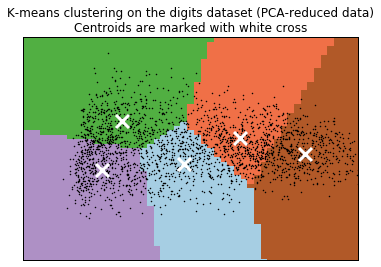

In [61]:
# Run k-means in reduced data and plot results 

data = tf_04
n_digits = 5

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
                   
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.xticks(())
plt.yticks(())
plt.show()

#Souce: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

In [76]:
# Run k-means using all features

kmeans = KMeans(n_clusters=5, random_state=1).fit(tf_04)
tf_02['kmeans'] = kmeans.predict(tf_04)

# Plot Most Bought Products per Cluster

In [79]:
products_analysis = pd.merge(data_full_01.reset_index(), tf_02['kmeans'].reset_index(),on=['user_id'], how='outer')

In [85]:
# Choosing cluster 0 to analyse results

df_0 = DataFrame(products_analysis[products_analysis.kmeans == 0]['product_name'].value_counts()[:10])

In [86]:
df_0['% of orders including product']= df_0['product_name']/len(set(products_analysis[products_analysis.kmeans == 0]['order_id']))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000039C64CF8>], dtype=object)

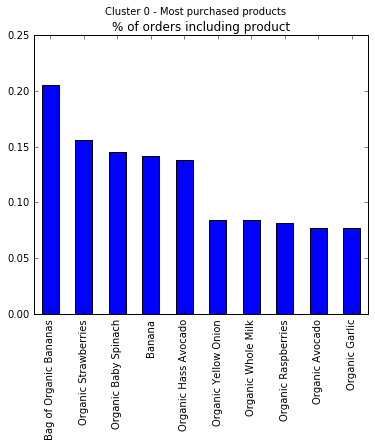

In [87]:
df_0 = df_0['% of orders including product']
df_0.plot(kind='bar', stacked=True, subplots=True, figsize=(6, 5), grid=False, title="Cluster 0 - Most purchased products")